# Analyze 2019 Michigan football play-calling

In [1]:
import requests
from collections import Counter
import lxml.html as lh
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join as opj

In [2]:
home_dir='/Users/steventompson/Git/stompson_blog'
data_dir=opj(home_dir,'anatomy_of_an_elite_offense','data')
fig_dir=opj(home_dir,'anatomy_of_an_elite_offense','figures')

In [3]:
url_list_2019=['2019-offense-vs-rutgers',
               '2019-offense-vs-wisconsin',
               '2019-offense-vs-army',
               '2019-offense-vs-mtsu']

In [4]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

pal1=sns.xkcd_palette(['goldenrod','navy'])
pal2=sns.xkcd_palette(["dusty purple","faded green"])
pal3=sns.xkcd_palette(['dark aquamarine','reddy brown'])
pal4=sns.xkcd_palette(['bluegrey','dark'])

In [5]:
def get_url_table(url_link):
    
    #Create a handle, page, to handle the contents of the website
    page = requests.get(url_link)
    #Store the contents of the website under doc
    doc = lh.fromstring(page.content)
    #Parse data that are stored between <tr>..</tr> of HTML
    tr_elements = doc.xpath('//tr')
    
    #parse table headers
    tr_elements = doc.xpath('//tr')
    #Create empty list
    col=[]
    i=0
    #For each row, store each first element (header) and an empty list
    for t in tr_elements[0]:
        i+=1
        name=t.text_content()
        #print '%d:"%s"'%(i,name)
        col.append((name,[]))
    
    col.append(('description',[]))
    return tr_elements,col


def get_url_df(tr_els,data_col):
    
    #Check the length of the first 12 rows to get play table
    n_cols=max([len(T) for T in tr_els[:12]])

    #Since out first row is the header, data is stored on the second row onwards
    for j in range(1,len(tr_els)):
        #T is our j'th row
        T=tr_els[j]
        
        if j<len(tr_els)-1:
            T2=tr_els[j+1]
            
        i=0
        #If row is not of max length n_cols, the //tr data is not from our table 
        if len(T)==n_cols and not T.text_content().startswith('\nLn'):    
            #Iterate through each element of the row
            for t in T.iterchildren():
                data=t.text_content() 
                #Check if row is empty
                if i>0:
                #Convert any numerical value to integers
                    try:
                        data=int(data)
                    except:
                        pass

                #Append the data to the empty list of the i'th column
                data_col[i][1].append(data)
                #Increment i for the next column
                i+=1
            data_col[i][1].append(T2.text_content())
    
    Dict={title:column for (title,column) in data_col}
    df=pd.DataFrame(Dict)
    df=df.replace('?',np.NaN)
    df=df.replace('???',np.NaN)
    df=df.replace('N/A',np.NaN)
    #df=df.replace('NA',np.NaN)
    return df  

In [6]:
def clean_df(df1,webtype='offense'):
    df1.columns=[f.replace(' ','') for f in df1.columns]
    if webtype=='offense':
        colnames_keep=['Ln','Dn','Ds','DForm','OForm','Box','WR','RB','TE','Play','Player','Type','Yards','description']
    else:
        colnames_keep=['Ln','Dn','Ds','DForm','OForm','Play','Player','Type','Yards','description']
    df1=df1.loc[:,colnames_keep]
    # Make everything lower-case
    for i,x in enumerate(df1.columns):
        text_vec=df1.loc[:,x].values
        for j,y in enumerate(text_vec):
            if isinstance(y,str):
                y=y.lower()
                if y.endswith(' '):
                    y=y[:-1]
            text_vec[j]=y
                
        df1.loc[:,x]=text_vec
    #Situational information (also include Dn and Box in situational information)
    df1['YTEZ']=100 #where on the field is the ball?
    df1['YTG']=999 #how many yards for 1st down or TD?
    df1['PassDown']=0 #0 for standard down, 1 for passing down
    df1['Block']=np.nan #number of blockers in the box on offense (5 + TEs + RBs - 1)
    df1['RollingAvg5']=0 # What percentage of previous 10 play calls were pass plays?
    df1['RollingAvg10']=0 # What percentage of previous 10 play calls were pass plays?
    df1['RollingAvg20']=0 # What percentage of previous 20 play calls were pass plays?
    df1['RollingAvg40']=0 # What percentage of previous 40 play calls were pass plays?
    df1['TypeNum']=0 # 0 for run, 1 for pass
    
    #Outcome information
    df1['YardsGained']=0 # How many yards did the play gain not including penalty yardage?
    df1['NetYards']=0 # How many yards did the play gain including penalty yardage?
    df1['Catch']=np.nan # If it was a pass, was the ball caught?
    df1['Success']=0 # Was the play successful not including penalties?
    df1['NetSuccess']=0 # Was the play successful including penalties?
    df1['3yds']=0 # Did the play get 3 yards?
    df1['PenaltyYards']=0 # Did the play result in any penalty yardage?
    df1['FirstDown']=0 # Did the play result in a first down?    
    df1['BigPlay']=0 # Did a running play gain at least 12 yards or a passing play gain at least 16 yards?
    df1['BigPlay10+']=0 # Did the play gain at least 10 yards?
    df1['BigPlay20+']=0 # Did the play gain at least 20 yards?
    df1['BigPlay30+']=0 # Did the play gain at least 30 yards?
    df1['BigPlay40+']=0 # Did the play gain at least 40 yards?
    
    for ix in df1.index.values:
        row=df1.loc[ix,:]
        ln=row['Ln']
        try:
            dn=int(row['Dn'])
        except:
            dn=row['Dn']
        ds=row['Ds']
        yards=row['Yards']
        ptype=row['Type']
        
        ### SITUATIONAL VARIABLES ###
        # Where on the field is the ball?
        if ln=='50 ' or ln=='50' or ln==50:
            df1.loc[ix,'YTEZ']=int(ln)   
        elif not pd.isnull(ln) and ln.startswith('m'):
            df1.loc[ix,'YTEZ']=100-int(ln[1:])
        else:
            df1.loc[ix,'YTEZ']=int(ln[1:])   

        # How many yards does the offense need to gain to get a first down or TD?
        if isinstance(ds,int):
            ytg=int(ds)
        elif ds=='g':
            ytg=df1.loc[ix,'YTEZ']
        elif ds=='pt':
            ytg=df1.loc[ix,'YTEZ']
        elif ds=='2pt':
            ytg=df1.loc[ix,'YTEZ']
        elif ds=='in':
            ytg=1
            
        df1.loc[ix,'YTG']=ytg
        # Was the play a standard down or passing down?
        if isinstance(dn,int) and dn==2 and ytg>=8:
            df1.loc[ix,'PassDown']=1
        elif isinstance(dn,int) and dn>=3 and ytg>=5:
            df1.loc[ix,'PassDown']=1
            
        # Rolling Average: what percentage of previous X plays were the same as the current play?
        #df1.loc[ix,'RollingAvg5']=np.mean(df1.loc[range(max(ix-5,0),ix),'Type']==ptype)
        #df1.loc[ix,'RollingAvg10']=np.mean(df1.loc[range(max(ix-10,0),ix),'Type']==ptype)
        #df1.loc[ix,'RollingAvg20']=np.mean(df1.loc[range(max(ix-20,0),ix),'Type']==ptype)
        #df1.loc[ix,'RollingAvg40']=np.mean(df1.loc[range(max(ix-40,0),ix),'Type']==ptype)

        # Rolling Average: what percentage of previous X plays were pass plays?
        df1.loc[ix,'RollingAvg5']=np.mean(df1.loc[range(max(ix-5,0),ix),'Type']=='pass')
        df1.loc[ix,'RollingAvg10']=np.mean(df1.loc[range(max(ix-10,0),ix),'Type']=='pass')
        df1.loc[ix,'RollingAvg20']=np.mean(df1.loc[range(max(ix-20,0),ix),'Type']=='pass')
        df1.loc[ix,'RollingAvg40']=np.mean(df1.loc[range(max(ix-40,0),ix),'Type']=='pass')
        
        # Play Type Number: assign 1 if it was a pass play
        if ptype=='pass':
            df1.loc[ix,'TypeNum']=1
        
        ### OUTCOME VARIABLES ###
        # How many yards did the play gain?
        if pd.isnull(yards):
            yg=np.nan
        elif isinstance(yards,int):
            yg=int(yards)
        elif 'pen' in yards:
            yg=np.nan
        elif yards.startswith('inc'):
            yg=0
        else:
            yg=0

        df1.loc[ix,'YardsGained']=yg
        df1.loc[ix,'NetYards']=yg
        
        if ptype=='pass':
            if not pd.isnull(yards) and isinstance(yards,int):
                df1.loc[ix,'Catch']=1
            elif not pd.isnull(yards) and 'inc' in yards:
                df1.loc[ix,'Catch']=0
                
        # Was the play successful?
        sval=yg/ytg
        if pd.isnull(yg):
            df1.loc[ix,'Success']=np.nan
            df1.loc[ix,'NetSuccess']=np.nan
        if isinstance(dn,int) and dn==1 and sval>=0.5:
            df1.loc[ix,'Success']=1
            df1.loc[ix,'NetSuccess']=1
        elif isinstance(dn,int) and dn==2 and sval>=0.7:
            df1.loc[ix,'Success']=1
            df1.loc[ix,'NetSuccess']=1
        elif isinstance(dn,int) and dn>2 and sval>=1.0:
            df1.loc[ix,'Success']=1
            df1.loc[ix,'NetSuccess']=1
            
            
        # Identify penalty yardage on play (especially for deep bombs that result in DPI)
        if not pd.isnull(yards) and not isinstance(yards,int) and not yards=='inc':
            if 'pen -' in yards:
                txt1=yards.split(' ')[0]
                txt2=yards.split(' ')[-1].replace(')','')
                try:
                    npy=int(txt2)
                except:
                    npy=0
                df1.loc[ix,'PenaltyYards']=npy

            elif not 'pen -' in yards:
                txt1=yards.split(' ')[0]
                txt2=yards.split(' ')[-1].replace(')','').replace('+','')
                try:
                    val1=int(txt1)
                except:
                    val1=0
                try:
                    npy=int(txt2)
                except:
                    npy=0
                total=val1+npy

                if total>yg:
                    yg=total
                df1.loc[ix,'PenaltyYards']=npy
                df1.loc[ix,'NetYards']=total
                df1.loc[ix,'NetSuccess']=1
                df1.loc[ix,'FirstDown']=1
                
        # Was the play a "big play"?
        if ptype=='pass' and yg>=16:
            df1.loc[ix,'BigPlay']=1
        if ptype=='run' and yg>=12:
            df1.loc[ix,'BigPlay']=1
            
        # Was the play a "BIG play"?
        if yg>=10:
            df1.loc[ix,'BigPlay10+']=1
        if yg>=20:
            df1.loc[ix,'BigPlay20+']=1
        if yg>=30:
            df1.loc[ix,'BigPlay30+']=1
        if yg>=40:
            df1.loc[ix,'BigPlay40+']=1
            
        # 3yds = did the play gain at least 3 yards?
        if yg>=3:
            df1.loc[ix,'3yds']=1
            
        # Did the play result in a 1st down?
        if yg>=ytg:
            df1.loc[ix,'FirstDown']==1
            
        
    return df1

In [7]:
def loop_over_urls(list_of_urls,year,webtype):
    comb_dict={}
    comb_df=pd.DataFrame()
    game_names=[t.replace('https://mgoblog.com/content/upon-further-review-','') for t in list_of_urls]
    for gname in game_names:
        print('Working on {}'.format(gname))
        #print('')
        url_link='https://mgoblog.com/content/upon-further-review-'+gname
        new_tr_els,new_cols=get_url_table(url_link)
        new_df=get_url_df(new_tr_els,new_cols)
        new_df2=clean_df(new_df,webtype)
        new_df2['Game']=gname
        new_df2['PlayNum']=new_df2.index.values
        comb_dict[gname]=new_df2
        comb_df=comb_df.append(new_df2)
    comb_df['Year']=year
    comb_df=comb_df.reset_index(drop=True)  
    return comb_df

In [8]:
off_df_2019=loop_over_urls(url_list_2019,2019,'offense')

Working on 2019-offense-vs-rutgers
Working on 2019-offense-vs-wisconsin
Working on 2019-offense-vs-army
Working on 2019-offense-vs-mtsu


In [9]:
off_df_2019.to_csv(opj(data_dir,'mgoblog_ufr','mgoblog_ufr_2019_first4games.csv'))

In [10]:
ixes=[ix for ix in off_df_2019.index if off_df_2019.loc[ix,'Type']=='pass' and off_df_2019.loc[ix,'Player']=='patterson' and off_df_2019.loc[ix,'Play']!='sack']
off_df_2019.loc[ixes,'Type']='run'
off_df_2019.loc[ixes,'Catch']=np.nan

In [11]:
def get_sub_df(df1,rem_pen=True,rem_goal='remove'):
    if rem_pen:
        df1=df1.loc[df1['Type']!='penalty']
        df1=df1.loc[df1['PenaltyYards']==0]
    if rem_goal=='remove':
        df1=df1.loc[df1['YTEZ']>10]
    elif rem_goal=='goal_only':
        df1=df1.loc[df1['YTEZ']<=10]
    df1=df1.reset_index(drop=True)
    return df1

off_df_nogoal=get_sub_df(off_df_2019)
off_df_goal=get_sub_df(off_df_2019,rem_goal='goal_only')


In [12]:
off_df_nogoal['Box']=off_df_nogoal['Box'].astype(float)
off_df_nogoal['Block']=5+off_df_nogoal['TE']+off_df_nogoal['RB']-1
off_df_nogoal['BlockDiff']=off_df_nogoal['Block']-off_df_nogoal['Box']
off_df_nogoal['BlockDisc']=0
off_df_nogoal.loc[off_df_nogoal['BlockDiff']<0,'BlockDisc']=-1
off_df_nogoal.loc[off_df_nogoal['BlockDiff']>0,'BlockDisc']=1

off_df_nogoal['3WR']=0
off_df_nogoal.loc[off_df_nogoal['WR']>=3,'3WR']=1

off_df_nogoal['StackedBox']=0
off_df_nogoal.loc[off_df_nogoal['Box']>=7,'StackedBox']=1

# Figure 2: Percentage of Plays Utilizing Spread Concepts

In [13]:
play_type_dict={}
#Spread terms
play_type_dict['spread']=['waggle','boot','rpo','read','option','qb','keeper']
play_type_dict['rpo']=['rpo']
play_type_dict['read option']=['read','option']
play_type_dict['qb']=['qb','keeper','option']
play_type_dict['waggle']=['waggle','boot']

#Running terms
play_type_dict['iz_run']=['inside zone','iz']
play_type_dict['sz_run']=['split zone']
play_type_dict['oz_run']=['outside zone','stretch']
play_type_dict['power_run']=['pin and pull','power','down']

#Passing terms
#play_type_dict['unknown_pass']=['hitch']
play_type_dict['deep_pass']=['seam','fly','punt','post','fade','corner']
play_type_dict['short_pass']=['slant','screen','angle','flat']
play_type_dict['int_pass']=['cross','dig','in','out','wheel','comeback','hitch']
play_type_dict['mid_pass']=['cross','slant','dig','in','post','angle']
play_type_dict['perim_pass']=['fade','screen','out','flat','wheel','comeback','corner']
#play_type_dict['exclude_pass']=['dumpoff','improv','sack','scramble','yakety sax']

plays_to_analyze=['inside zone','split zone','outside zone','stretch',
                  'pin and pull','power','down',
                  'arc','iz','keeper','qb','scramble','rpo',
                  'screen','pa','waggle','out','cross','slant','fade','hitch']

statvars=['YardsGained','Success','Catch','3yds','BigPlay','BigPlay10+','BigPlay20+']

off_df_nogoal['spread']=0
spread_ixes=np.unique([ix for ix,play in enumerate(off_df_nogoal['Play']) for p in play_type_dict['spread'] if not pd.isnull(play) and p in play]).tolist()
off_df_nogoal.loc[spread_ixes,'spread']=1

off_df_nogoal['short_pass']=0
short_ixes=np.unique([ix for ix,play in enumerate(off_df_nogoal['Play']) for p in play_type_dict['short_pass'] if not pd.isnull(play) and p in play]).tolist()
off_df_nogoal.loc[short_ixes,'short_pass']=1

off_df_nogoal['spread+']=0
spreadplus_ixes=np.unique(spread_ixes+short_ixes).tolist()
off_df_nogoal.loc[spreadplus_ixes,'spread+']=1

off_df_nogoal['perim']=0
perim_ixes=np.unique([ix for ix,play in enumerate(off_df_nogoal['Play']) for p in play_type_dict['perim_pass'] if not pd.isnull(play) and p in play]).tolist()
off_df_nogoal.loc[perim_ixes,'perim']=1

off_df_nogoal['top_wrs']=0
topwr_ixes=np.unique([ix for ix,player in enumerate(off_df_nogoal['Player']) if not pd.isnull(player) and player in ['bell','collins','dpj','black']]).tolist()
off_df_nogoal.loc[topwr_ixes,'top_wrs']=1

        3WR  Play  Percentage
spread                       
0         2   195    0.840517
1         2    37    0.159483
            Play  Percentage
spread 3WR                  
0      0      68    0.293103
       1     127    0.547414
1      0      14    0.060345
       1      23    0.099138
                 Play  Percentage
spread 3WR Type                  
0      0   pass    29    0.125000
           run     39    0.168103
       1   pass    87    0.375000
           run     40    0.172414
1      0   pass     8    0.034483
           run      6    0.025862
       1   pass     7    0.030172
           run     16    0.068966


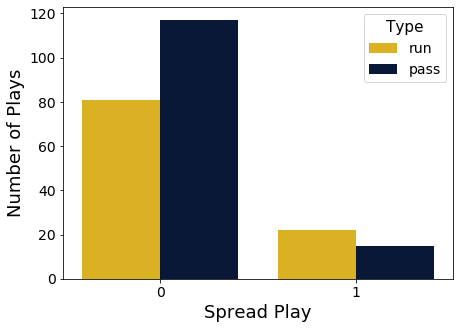

<Figure size 504x360 with 0 Axes>

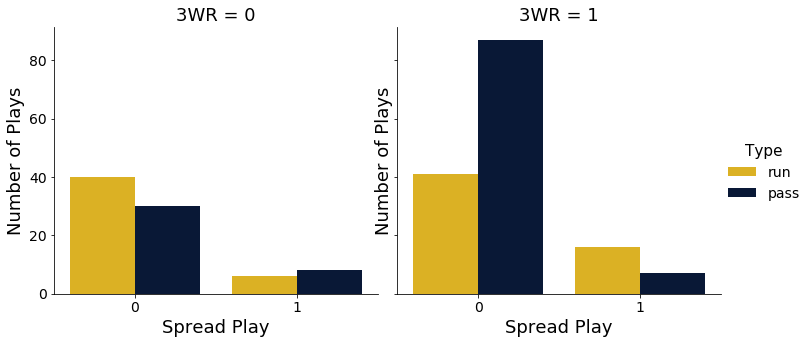

<Figure size 504x360 with 0 Axes>

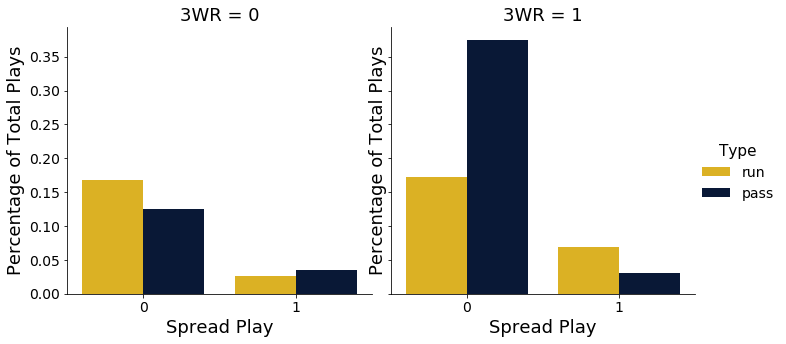

In [14]:
sum_df=off_df_nogoal.loc[:,['spread','3WR','Type','Play']].groupby(['spread','3WR','Type']).count().reset_index()
sum_df['Percentage']=sum_df['Play']/sum_df['Play'].sum()


print(sum_df.groupby(['spread']).sum())
print(sum_df.groupby(['spread','3WR']).sum())
print(sum_df.groupby(['spread','3WR','Type']).sum())

plt.figure(figsize=(7,5))
ax=sns.countplot(x='spread',hue='Type',hue_order=['run','pass'],data=off_df_nogoal,palette=pal1)
ax.set(xlabel='Spread Play', ylabel='Number of Plays')
#ax.set_ylim([3,8])
#plt.savefig(opj(fig_dir,'spread_ypp.png'),bbox_inches='tight')
plt.show()

plt.figure(figsize=(7,5))
ax=sns.catplot(x='spread',hue='Type',hue_order=['run','pass'],col='3WR',data=off_df_nogoal,palette=pal1,kind='count')
ax.set(xlabel='Spread Play', ylabel='Number of Plays')
#ax.set_ylim([3,8])
#plt.savefig(opj(fig_dir,'spread_ypp.png'),bbox_inches='tight')
plt.show()

plt.figure(figsize=(7,5))
ax=sns.catplot(x='spread',y='Percentage',hue='Type',hue_order=['run','pass'],col='3WR',data=sum_df,palette=pal1,kind='bar')
ax.set(xlabel='Spread Play', ylabel='Percentage of Total Plays')
#ax.set_ylim([3,8])
plt.savefig(opj(fig_dir,'fig2a.png'),bbox_inches='tight')
plt.show()

            3WR  Play  Percentage
short_pass                       
0             2   205    0.883621
1             1    27    0.116379
                Play  Percentage
short_pass 3WR                  
0          0      71    0.306034
           1     134    0.577586
1          0      11    0.047414
           1      16    0.068966
                     Play  Percentage
short_pass 3WR Type                  
0          0   pass    26    0.112069
               run     45    0.193966
           1   pass    78    0.336207
               run     56    0.241379
1          0   pass    11    0.047414
           1   pass    16    0.068966


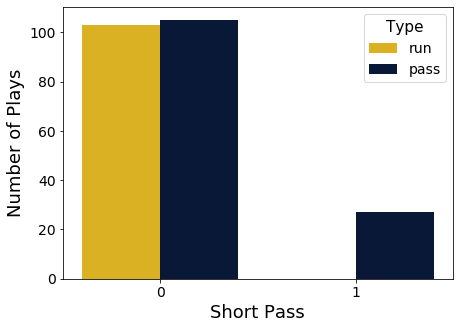

<Figure size 504x360 with 0 Axes>

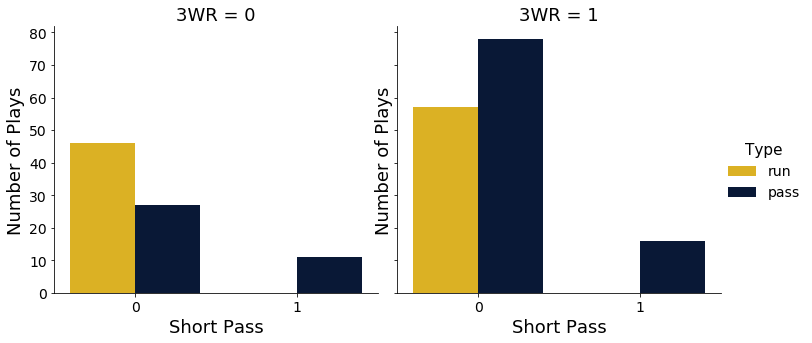

<Figure size 504x360 with 0 Axes>

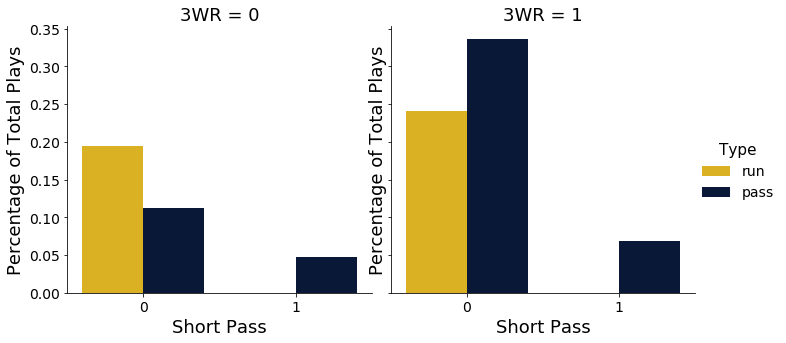

In [15]:
sum_df=off_df_nogoal.loc[:,['short_pass','3WR','Type','Play']].groupby(['short_pass','3WR','Type']).count().reset_index()
sum_df['Percentage']=sum_df['Play']/sum_df['Play'].sum()

print(sum_df.groupby(['short_pass']).sum())
print(sum_df.groupby(['short_pass','3WR']).sum())
print(sum_df.groupby(['short_pass','3WR','Type']).sum())



plt.figure(figsize=(7,5))
ax=sns.countplot(x='short_pass',hue='Type',hue_order=['run','pass'],data=off_df_nogoal,palette=pal1)
ax.set(xlabel='Short Pass', ylabel='Number of Plays')
#ax.set_ylim([3,8])
#plt.savefig(opj(fig_dir,'spread_ypp.png'),bbox_inches='tight')
plt.show()

plt.figure(figsize=(7,5))
ax=sns.catplot(x='short_pass',hue='Type',hue_order=['run','pass'],col='3WR',data=off_df_nogoal,palette=pal1,kind='count')
ax.set(xlabel='Short Pass', ylabel='Number of Plays')
#ax.set_ylim([3,8])
#plt.savefig(opj(fig_dir,'spread_ypp.png'),bbox_inches='tight')
plt.show()

plt.figure(figsize=(7,5))
ax=sns.catplot(x='short_pass',y='Percentage',hue='Type',hue_order=['run','pass'],col='3WR',data=sum_df,palette=pal1,kind='bar')
ax.set(xlabel='Short Pass', ylabel='Percentage of Total Plays')
#ax.set_ylim([3,8])
#plt.savefig(opj(fig_dir,'spread_ypp.png'),bbox_inches='tight')
plt.show()

         3WR  Play  Percentage
spread+                       
0          2   179    0.771552
1          2    53    0.228448
             Play  Percentage
spread+ 3WR                  
0       0      62    0.267241
        1     117    0.504310
1       0      20    0.086207
        1      33    0.142241
                  Play  Percentage
spread+ 3WR Type                  
0       0   pass    23    0.099138
            run     39    0.168103
        1   pass    77    0.331897
            run     40    0.172414
1       0   pass    14    0.060345
            run      6    0.025862
        1   pass    17    0.073276
            run     16    0.068966


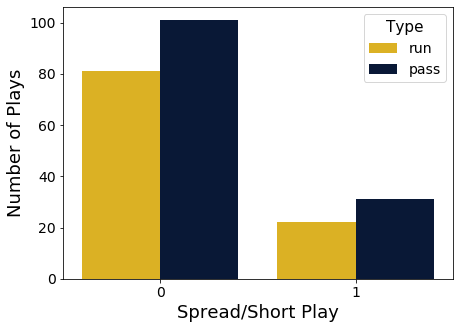

<Figure size 720x360 with 0 Axes>

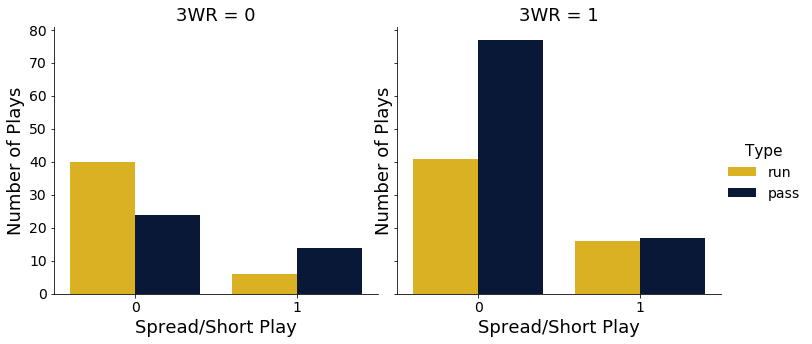

<Figure size 720x360 with 0 Axes>

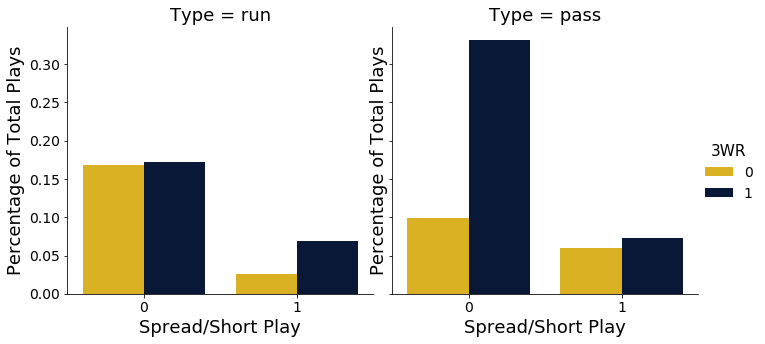

In [23]:
sum_df=off_df_nogoal.loc[:,['spread+','3WR','Type','Play']].groupby(['spread+','3WR','Type']).count().reset_index()
sum_df['Percentage']=sum_df['Play']/sum_df['Play'].sum()

print(sum_df.groupby(['spread+']).sum())
print(sum_df.groupby(['spread+','3WR']).sum())
print(sum_df.groupby(['spread+','3WR','Type']).sum())


plt.figure(figsize=(7,5))
ax=sns.countplot(x='spread+',hue='Type',hue_order=['run','pass'],data=off_df_nogoal,palette=pal1)
ax.set(xlabel='Spread/Short Play', ylabel='Number of Plays')
#ax.set_ylim([3,8])
#plt.savefig(opj(fig_dir,'spread_ypp.png'),bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,5))
ax=sns.catplot(x='spread+',hue='Type',hue_order=['run','pass'],col='3WR',data=off_df_nogoal,palette=pal1,kind='count')
ax.set(xlabel='Spread/Short Play', ylabel='Number of Plays')
#ax.set_ylim([3,8])
#plt.savefig(opj(fig_dir,'spread_ypp.png'),bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,5))
#ax=sns.catplot(x='spread+',y='Percentage',hue='Type',hue_order=['run','pass'],col='3WR',data=sum_df,palette=pal1,kind='bar')
ax=sns.catplot(x='spread+',y='Percentage',hue='3WR',col='Type',col_order=['run','pass'],data=sum_df,palette=pal1,kind='bar')
ax.set(xlabel='Spread/Short Play', ylabel='Percentage of Total Plays')
#ax.set_ylim([3,8])
plt.savefig(opj(fig_dir,'fig2c.png'),bbox_inches='tight')
plt.show()

# Figure 3: Effectiveness of Spread-Type Plays

<Figure size 720x360 with 0 Axes>

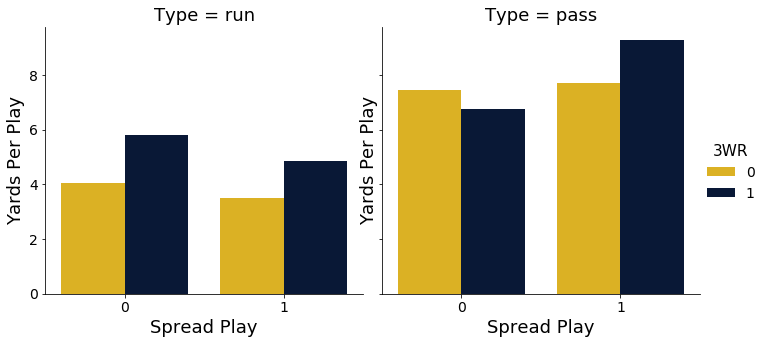

<Figure size 720x360 with 0 Axes>

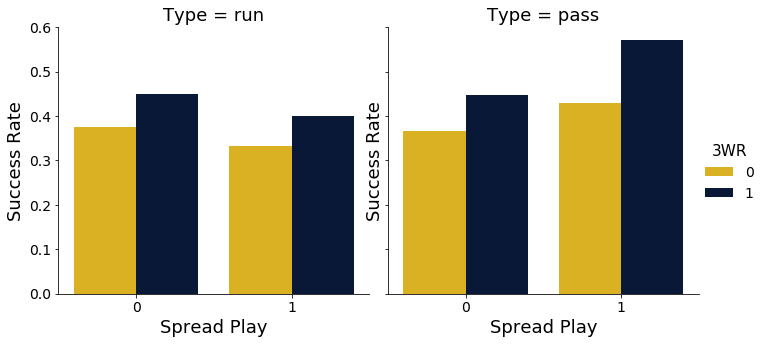

In [22]:
plt.figure(figsize=(10,5))
ax=sns.catplot(x='spread',y='YardsGained',hue='3WR',col='Type',data=off_df_nogoal,palette=pal1,kind='bar',ci=None)
ax.set(xlabel='Spread Play', ylabel='Yards Per Play')
#ax.set_ylim([3,9])
plt.savefig(opj(fig_dir,'fig3a.png'),bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,5))
ax=sns.catplot(x='spread',y='Success',hue='3WR',col='Type',data=off_df_nogoal,palette=pal1,kind='bar',ci=None)
ax.set(xlabel='Spread Play', ylabel='Success Rate')
#ax.set_ylim([0.2,0.7])
plt.savefig(opj(fig_dir,'fig3b.png'),bbox_inches='tight')
plt.show()

# Figures 4 and 5: Usage for Top-4 WRs

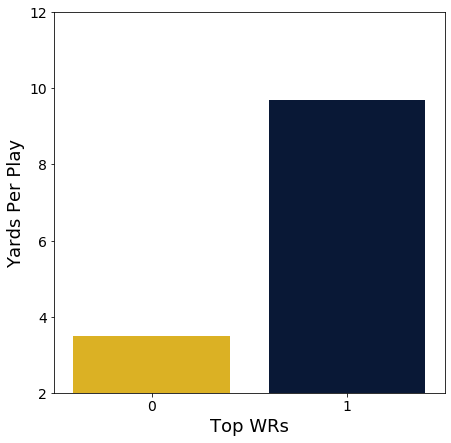

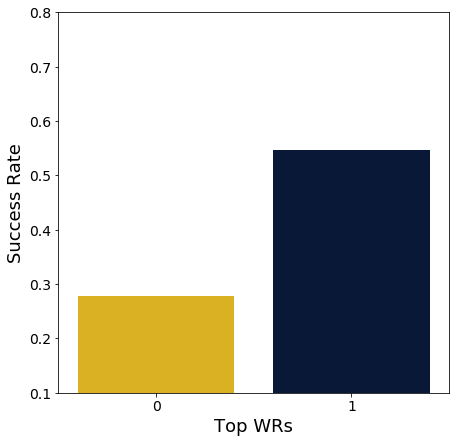

In [20]:
plt.figure(figsize=(7,7))
#ax=sns.catplot(x='top_wrs',y='YardsGained',col='Game',col_order=['2019-offense-vs-mtsu','2019-offense-vs-army','2019-offense-vs-wisconsin','2019-offense-vs-rutgers'],
#               data=off_df_nogoal.loc[off_df_nogoal['Type']=='pass',:],palette=pal1,kind='bar',ci=None)
ax=sns.barplot(x='top_wrs',y='YardsGained',
               data=off_df_nogoal.loc[off_df_nogoal['Type']=='pass',:],palette=pal1,ci=None)

ax.set(xlabel='Top WRs', ylabel='Yards Per Play')
ax.set_ylim([2,12])
plt.savefig(opj(fig_dir,'fig4a.png'),bbox_inches='tight')
plt.show()

plt.figure(figsize=(7,7))
#ax=sns.catplot(x='top_wrs',y='Success',col='Game',col_order=['2019-offense-vs-mtsu','2019-offense-vs-army','2019-offense-vs-wisconsin','2019-offense-vs-rutgers'],
#               data=off_df_nogoal.loc[off_df_nogoal['Type']=='pass',:],palette=pal1,kind='bar',ci=None)
ax=sns.barplot(x='top_wrs',y='Success',
               data=off_df_nogoal.loc[off_df_nogoal['Type']=='pass',:],palette=pal1,ci=None)
ax.set(xlabel='Top WRs', ylabel='Success Rate')
ax.set_ylim([0.1,0.8])
plt.savefig(opj(fig_dir,'fig4b.png'),bbox_inches='tight')
plt.show()

         3WR  Play  Percentage
top_wrs                       
0          2   156    0.672414
1          2    76    0.327586
              3WR  Play  Percentage
top_wrs Type                       
0       pass    1    56    0.241379
        run     1   100    0.431034
1       pass    1    75    0.323276
        run     1     1    0.004310
                  Play  Percentage
top_wrs 3WR Type                  
0       0   pass    22    0.094828
            run     45    0.193966
        1   pass    34    0.146552
            run     55    0.237069
1       0   pass    15    0.064655
        1   pass    60    0.258621
            run      1    0.004310


<Figure size 720x360 with 0 Axes>

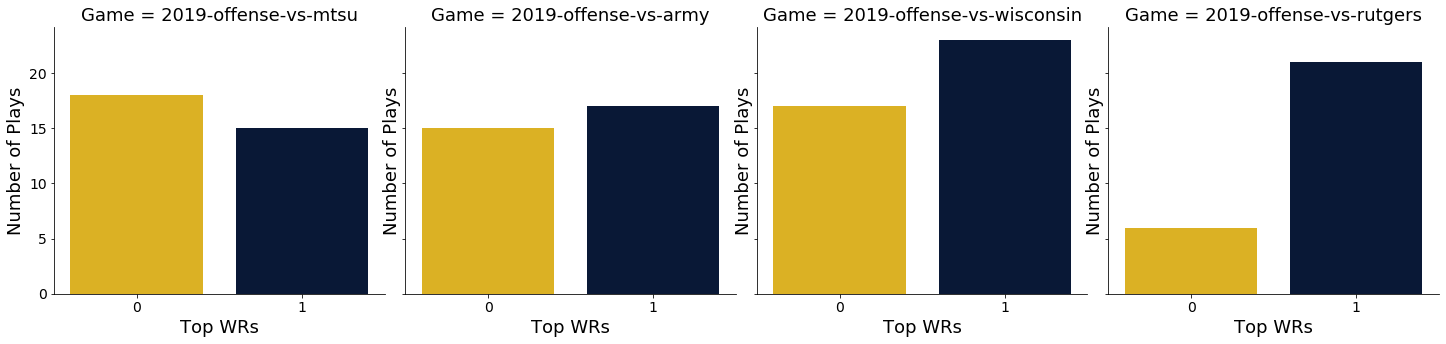

In [21]:
sum_df=off_df_nogoal.loc[:,['top_wrs','3WR','Type','Play']].groupby(['top_wrs','3WR','Type']).count().reset_index()
sum_df['Percentage']=sum_df['Play']/sum_df['Play'].sum()

print(sum_df.groupby(['top_wrs']).sum())
print(sum_df.groupby(['top_wrs','Type']).sum())
print(sum_df.groupby(['top_wrs','3WR','Type']).sum())

plt.figure(figsize=(10,5))
ax=sns.catplot(x='top_wrs',col='Game',col_order=['2019-offense-vs-mtsu','2019-offense-vs-army','2019-offense-vs-wisconsin','2019-offense-vs-rutgers'],
               data=off_df_nogoal.loc[off_df_nogoal['Type']=='pass',:],palette=pal1,kind='count')
ax.set(xlabel='Top WRs', ylabel='Number of Plays')
#ax.set_ylim([3,8])
plt.savefig(opj(fig_dir,'fig5.png'),bbox_inches='tight')
plt.show()

#plt.figure(figsize=(7,5))
#ax=sns.catplot(x='top_wrs',y='Percentage',hue='Type',hue_order=['run','pass'],col='Game',data=sum_df,palette='Set2',kind='bar')
#ax.set(xlabel='Spread/Short Play', ylabel='Percentage of Total Plays')
#ax.set_ylim([3,8])
#plt.savefig(opj(fig_dir,'spread_ypp.png'),bbox_inches='tight')
#plt.show()

# Scratchpad

In [ ]:
sum_df=pd.DataFrame(index=['spread_run','spread_pass','nospread_run','nospread_pass'],columns=statvars+['Count']).reset_index()


In [ ]:
get_playgroup_stats(off_df_nogoal,play_type_dict['spread'],'Play',statvars,ptype='pass')

In [ ]:
off_df_nogoal.loc[:,['YardsGained','Success','BigPlay20+',]].mean()

In [ ]:
plt.figure(figsize=(10,5))
ax=sns.barplot(x='index',y='YardsGained',data=sum_df_spread,palette='Set2')
ax.set(xlabel='Play Type', ylabel='Yards Per Play')
#ax.set_ylim([0,0.4])
#plt.savefig(opj(fig_dir,'spread_ypp.png'),bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(7,5))
ax=sns.barplot(x='spread',y='YardsGained',data=off_df_nogoal,palette='Set2',ci=None)
ax.set(xlabel='Spread Play', ylabel='Yards Per Play')
ax.set_ylim([3,8])
#plt.savefig(opj(fig_dir,'spread_ypp.png'),bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(7,5))
ax=sns.barplot(x='3WR',y='YardsGained',hue='Type',hue_order=['run','pass'],data=off_df_nogoal,palette='Set2',ci=None)
ax.set(xlabel='3+ WR', ylabel='Yards Per Play')
ax.set_ylim([2.5,9.5])
plt.savefig(opj(fig_dir,'3wr_ypp.png'),bbox_inches='tight')
plt.show()

plt.figure(figsize=(7,5))
ax=sns.barplot(x='3WR',y='Success',hue='Type',hue_order=['run','pass'],data=off_df_nogoal,palette='Set2',ci=None)
ax.set(xlabel='3+ WR', ylabel='Success Rate')
ax.set_ylim([0.2,0.6])
plt.savefig(opj(fig_dir,'3wr_srate.png'),bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(7,5))
ax=sns.barplot(x='Type',y='YardsGained',hue='3WR',data=off_df_nogoal,palette='Set2',ci=None)
ax.set(xlabel='Play Type', ylabel='Yards Per Play')
ax.set_ylim([2.5,9.5])
plt.savefig(opj(fig_dir,'3wr_type_ypp.png'),bbox_inches='tight')
plt.show()

plt.figure(figsize=(7,5))
ax=sns.barplot(x='Type',y='Success',hue='3WR',data=off_df_nogoal,palette='Set2',ci=None)
ax.set(xlabel='Play Type', ylabel='Success Rate')
ax.set_ylim([0.2,0.6])
plt.savefig(opj(fig_dir,'3wr_type_srate.png'),bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(7,5))
ax=sns.barplot(x='Type',y='YardsGained',hue='spread',data=off_df_nogoal,palette='RdBu',ci=None)
ax.set(xlabel='Play Type', ylabel='Yards Per Play')
ax.set_ylim([2.5,9.5])
plt.savefig(opj(fig_dir,'spread_type_ypp.png'),bbox_inches='tight')
plt.show()

plt.figure(figsize=(7,5))
ax=sns.barplot(x='Type',y='Success',hue='spread',data=off_df_nogoal,palette='RdBu',ci=None)
ax.set(xlabel='Play Type', ylabel='Success Rate')
ax.set_ylim([0.2,0.6])
plt.savefig(opj(fig_dir,'spread_type_srate.png'),bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(7,5))
ax=sns.catplot(x='spread+',y='YardsGained',hue='3WR',col='Type',data=off_df_nogoal,palette='Set2',kind='bar',ci=None)
ax.set(xlabel='Spread/Short Play', ylabel='Yards Per Play')
#ax.set_ylim([2,8])
#plt.savefig(opj(fig_dir,'spread_ypp.png'),bbox_inches='tight')
plt.show()

plt.figure(figsize=(7,5))
ax=sns.catplot(x='spread+',y='Success',hue='3WR',col='Type',data=off_df_nogoal,palette='Set2',kind='bar',ci=None)
ax.set(xlabel='Spread/Short Play', ylabel='Success Rate')
#ax.set_ylim([2,8])
#plt.savefig(opj(fig_dir,'spread_ypp.png'),bbox_inches='tight')
plt.show()

In [ ]:
off_df_nogoal.loc[off_df_nogoal['spread+']]

In [ ]:
plt.figure(figsize=(7,5))
ax=sns.barplot(x='spread+',y='YardsGained',data=off_df_nogoal,palette='Set2',ci=None)
ax.set(xlabel='Play Type', ylabel='Yards Per Play')
ax.set_ylim([3,8])
plt.savefig(opj(fig_dir,'spread_ypp.png'),bbox_inches='tight')
plt.show()

In [ ]:

def custom_catplot(df1,xvar,yvar,huevar,colvar,kind='bar',ci=None):
    if kind=='bar':
        gvals=df1.loc[:,[xvar,yvar,huevar,colvar]].groupby([xvar,huevar,colvar]).mean().reset_index()
    elif kind=='count':
        gvals=df1.loc[:,[xvar,yvar,huevar,colvar]].groupby([xvar,huevar,colvar]).count().reset_index()
    g=sns.catplot(x=xvar,y=yvar,hue=huevar,col=colvar,data=df1,kind=kind,ci=ci)
    for index, row in gvals.iterrows():
        g.text(row.name,row[xvar], round(row[yvar],2), color='black', ha="center")

        
#custom_catplot(off_df_nogoal,xvar='3WR',yvar='Success',huevar='Type',colvar='StackedBox')
sns.catplot(x='3WR',y='YardsGained',hue='Type',col='StackedBox',data=off_df_nogoal,kind='bar',ci=None)
plt.show()
ax=sns.countplot(x='3WR',hue='StackedBox',data=off_df_nogoal.loc[off_df_nogoal['BigPlay30+']==1,:],palette='Set2')
#ax=sns.countplot(x='3WR',data=off_df_nogoal.loc[off_df_nogoal['BigPlay30+']==1,:],palette='Set2')
ax.set_ylim([0,10])
ax.legend(loc='upper left',title='Stacked Box')
plt.show()
sns.catplot(x='3WR',y='Success',hue='Type',col='StackedBox',data=off_df_nogoal,kind='bar',ci=None)
plt.show()
#g.set_ylim([0,0.6])
#g.map(plt.bar, '3WR', 'Success', yerr=0)
sns.catplot(x='StackedBox',hue='Type',col='3WR',data=off_df_nogoal,kind='count')
plt.show()

In [ ]:
sns.catplot(x='spread',y='YardsGained',hue='Type',col='3WR',data=off_df_nogoal,kind='bar',ci=None)
plt.show()
ax=sns.countplot(x='spread',hue='3WR',data=off_df_nogoal.loc[off_df_nogoal['BigPlay20+']==1,:],palette='Set2')
#ax=sns.countplot(x='3WR',data=off_df_nogoal.loc[off_df_nogoal['BigPlay30+']==1,:],palette='Set2')
ax.set_ylim([0,20])
ax.legend(loc='upper left',title='3WR')
plt.show()
sns.catplot(x='spread',y='Success',hue='Type',col='3WR',data=off_df_nogoal,kind='bar',ci=None)
plt.show()
#g.set_ylim([0,0.6])
#g.map(plt.bar, '3WR', 'Success', yerr=0)
sns.catplot(x='3WR',hue='Type',col='spread',data=off_df_nogoal,kind='count')
plt.show()

In [ ]:
sns.catplot(x='3WR',y='YardsGained',hue='Type',col='perim',data=off_df_nogoal,kind='bar',ci=None)
plt.show()
ax=sns.countplot(x='3WR',hue='perim',data=off_df_nogoal.loc[off_df_nogoal['BigPlay20+']==1,:],palette='Set2')
#ax=sns.countplot(x='3WR',data=off_df_nogoal.loc[off_df_nogoal['BigPlay30+']==1,:],palette='Set2')
ax.set_ylim([0,20])
ax.legend(loc='upper left',title='perimeter')
plt.show()
sns.catplot(x='3WR',y='Success',hue='Type',col='perim',data=off_df_nogoal,kind='bar',ci=None)
plt.show()
#g.set_ylim([0,0.6])
#g.map(plt.bar, '3WR', 'Success', yerr=0)
sns.catplot(x='perim',hue='Type',col='3WR',data=off_df_nogoal,kind='count')
plt.show()

In [ ]:
rutgers=off_df_nogoal.loc[off_df_nogoal['Game']=='2019-offense-vs-rutgers',:].reset_index(drop=True)
#rutgers.loc[:,['Play','Player']]
ixes=[ix for ix,play in enumerate(rutgers['Play']) if keyword in play]
print(len(ixes))
print(np.sum(rutgers['Type']=='pass'))
np.mean(rutgers['WR']>=3)

In [ ]:
get_playgroup_stats(rutgers,play_type_dict['spread'],'Play',statvars,ptype='all')

In [ ]:
get_playgroup_stats(rutgers,play_type_dict['spread'],'Play',statvars,ptype='run')

In [ ]:
def plot_2factor_means(df1,var1,var2,dvar,xlab='',ylab='',plotsave=False,savename='',ylims=None):
    keepvars=np.unique(['3WR','Box','StackedBox','Type','YardsGained','Success','3yds','BigPlay10+','BigPlay20+']+[var1,var2,dvar]).tolist()
    sum_df=df1.loc[:,keepvars].groupby([var1,var2]).mean().reset_index()
    sum_df['Count']=df1.loc[:,[var1,var2,'Play']].groupby([var1,var2]).count().values
    #sum_df_3wr.loc[sum_df_3wr['Type']=='pass','Percentage']=sum_df_3wr.loc[sum_df_3wr['Type']=='pass','Count']/pass_play_count
    #sum_df_3wr.loc[sum_df_3wr['Type']=='run','Percentage']=sum_df_3wr.loc[sum_df_3wr['Type']=='run','Count']/run_play_count
    sum_df['Percentage']=sum_df['Count']/len(df1['Play'].dropna())
                       
    plt.figure(figsize=(10,5))
    ax=sns.barplot(x=var1,y=dvar,hue=var2,data=sum_df,palette='Set2')
    ax.set(xlabel=xlab, ylabel=ylab)
    if ylims is not None:
        ax.set_ylim(ylims)
    if plotsave:
        plt.savefig(opj(fig_dir,savename),bbox_inches='tight')
    plt.show()    
    return sum_df

def plot_3factor_means(df1,var1,var2,var3,dvar,xlab='',ylab='',plotsave=False,savename='',ylims=None):
    keepvars=np.unique(['3WR','Box','StackedBox','Type','YardsGained','Success','3yds','BigPlay10+','BigPlay20+']+[var1,var2,dvar]).tolist()
    sum_df=df1.loc[:,keepvars].groupby([var1,var2]).mean().reset_index()
    sum_df['Count']=df1.loc[:,[var1,var2,'Play']].groupby([var1,var2]).count().values
    #sum_df_3wr.loc[sum_df_3wr['Type']=='pass','Percentage']=sum_df_3wr.loc[sum_df_3wr['Type']=='pass','Count']/pass_play_count
    #sum_df_3wr.loc[sum_df_3wr['Type']=='run','Percentage']=sum_df_3wr.loc[sum_df_3wr['Type']=='run','Count']/run_play_count
    sum_df['Percentage']=sum_df['Count']/len(df1['Play'].dropna())
                       
    plt.figure(figsize=(10,5))
    ax=sns.barplot(x=var1,y=dvar,hue=var2,data=sum_df,palette='Set2')
    ax.set(xlabel=xlab, ylabel=ylab)
    if ylims is not None:
        ax.set_ylim(ylims)
    if plotsave:
        plt.savefig(opj(fig_dir,savename),bbox_inches='tight')
    plt.show()    
    return sum_df

In [ ]:
dvarlist=['Percentage','YardsGained','Success','StackedBox','Box']
dvarnames=['Percentage of Total Plays','Yards Per Play','Success Rate','Stacked Box Percentage','Number of Box Defenders']
ylim_list=[[0,0.6],[2,10],[0.2,0.6],[0,1],[4,8]]
for ix,dvar in enumerate(dvarlist):
    dvarname=dvarnames[ix]
    ylim_vals=ylim_list[ix]
    sum_df_3wr=plot_2factor_means(df1=off_df_nogoal,var1='3WR',var2='Type',dvar=dvar,xlab='3+ WRs',ylab=dvarname,ylims=ylim_vals)

In [ ]:
dvarlist=['Percentage','YardsGained','Success','3WR','WR']
dvarnames=['Percentage of Total Plays','Yards Per Play','Success Rate','3+ WR Percentage','Number of WRs']
ylim_list=[[0,0.6],[2,10],[0.2,0.6],[0,1],[0,4]]
for ix,dvar in enumerate(dvarlist):
    dvarname=dvarnames[ix]
    ylim_vals=ylim_list[ix]
    sum_df_3wr=plot_2factor_means(df1=off_df_nogoal,var1='StackedBox',var2='Type',dvar=dvar,xlab='Stacked Box',ylab=dvarname,ylims=ylim_vals)

In [ ]:
off_df_nogoal.loc[:,['3WR','Type','Play']].groupby(['3WR','Type']).count()

In [ ]:
plt.figure(figsize=(10,5))
ax=sns.barplot(x='3WR',y='YardsGained',hue='Type',data=sum_df_3wr,palette='Set2')
ax.set(xlabel='3+ WRs', ylabel='Yards Per Play')
ax.set_ylim([2,10])
plt.savefig(opj(fig_dir,'wr3_ypp.png'),bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
ax=sns.barplot(x='3WR',y='Success',hue='Type',data=sum_df_3wr,palette='Set2')
ax.set(xlabel='3+ WRs', ylabel='Success Rate')
ax.set_ylim([0.3,0.6])
plt.axhline(y=0.45,color='black')
plt.savefig(opj(fig_dir,'wr3_ypp.png'),bbox_inches='tight')
plt.show()

In [ ]:
sum_df_sb=off_df_nogoal.loc[:,['3WR','Box','StackedBox','Type','YardsGained','Success','3yds','BigPlay10+','BigPlay20+']].groupby(['StackedBox','Type']).mean()
sum_df_sb=sum_df_sb.reset_index()
sum_df_sb['Count']=off_df_nogoal.loc[:,['StackedBox','Type','YardsGained']].groupby(['StackedBox','Type']).count().values
sum_df_sb['Percentage']=sum_df_sb['Count']/total_play_count

In [ ]:
plt.figure(figsize=(7,5))
ax=sns.barplot(x='StackedBox',y='YardsGained',hue='Type',data=sum_df_sb,palette='Set2')
ax.set(xlabel='Stacked Box', ylabel='Yards Per Play')
ax.set_ylim([2,10])
plt.savefig(opj(fig_dir,'stackedbox_ypp.png'),bbox_inches='tight')
plt.show()

# Analyze situational variables

In [ ]:
off_df_nogoal['Box']=off_df_nogoal['Box'].astype(float)
off_df_nogoal['Block']=5+off_df_nogoal['TE']+off_df_nogoal['RB']-1
off_df_nogoal['BlockDiff']=off_df_nogoal['Block']-off_df_nogoal['Box']
off_df_nogoal['BlockDisc']=0
off_df_nogoal.loc[off_df_nogoal['BlockDiff']<0,'BlockDisc']=-1
off_df_nogoal.loc[off_df_nogoal['BlockDiff']>0,'BlockDisc']=1

In [ ]:
def assign_labels(df1,ixvar,newvar,list1,label1,create_newvar=False):
    if create_newvar:
        df1[newvar]='NA'
    
    ixes=[ix for ix,val in enumerate(df1[ixvar]) if val in list1]
    df1.loc[ixes,newvar]=label1
    return df1


wr1s=['bell','dpj','collins','black']
wr2s=['jackson','johnson','sainristil']
wrs=wr1s+wr2s
tes=['mckeon','eubanks','schoonmaker']
passcathers=wrs+tes
rb1s=['charbonnet','turner','haskins']
rb2s=['bvs','capitinia','vansumeren','wilson']
rbs=rb1s+rb2s
pass_others=wr2s+rbs+['schoonmaker']
qb1s=['patterson','mccaffrey']
qbs=qb1s+['milton']
rbs_plus_qbs=rb1s+qb1s
off_df_nogoal=assign_labels(off_df_nogoal,'Player','Position',qbs,'QB',create_newvar=True)
off_df_nogoal=assign_labels(off_df_nogoal,'Player','Position',wrs,'WR')
off_df_nogoal=assign_labels(off_df_nogoal,'Player','Position',tes,'TE')
off_df_nogoal=assign_labels(off_df_nogoal,'Player','Position',rbs,'RB')

In [ ]:

columns=['Game','Type','PassDown','Box','Block','BlockDiff','YardsGained','Success','3yds','Catch',#'RollingAvg10','NetYards','NetSuccess',
        'BigPlay','BigPlay10+','BigPlay20+','BigPlay30+','BigPlay40+']

#Insight: Michigan is more effective passing than running right now, 
#and there is a lack of big plays, especially for run game
#Note: NCAA averages for passing game in 2017 were 7.8 YPT and 62% completion rate with a 45% success rate
#Note: Not sure about running game, but think 4-5 ypc and a 45% success rate is common
off_df_nogoal.loc[:,columns].groupby(['Type']).mean()

In [ ]:
#Insight: Michigan is actually pretty effective on run downs (but need to compare to other Os), 
#but not effective on passing downs (worse success rate, and only 1 30+ yard play on passing down)
off_df_nogoal.loc[:,columns].groupby(['Type','PassDown']).mean()

In [ ]:
#Insight: QB runs are generally better than RB runs (although scrambles for neg yardage hurt), WR receptions are generally better than TE receptions
#Cut the frippery: WR runs and RB catches are BAD (9 RB catches and 3 WR runs for under 3 ypp)
#NOTE: need to split out designed QB runs versus scrambles
off_df_nogoal.loc[:,columns+['Position']].groupby(['Type','Position']).mean()

In [ ]:
#Insight: When there are more box defenders than blockers, QB runs are way more effective
off_df_nogoal.loc[off_df_nogoal['Type']=='run',columns+['Position','BlockDisc']].groupby(['Type','BlockDisc','Position']).mean()

In [ ]:
#Insight (but obvious): Vast majority of plays with blocking deficit have 3+ WRs
#Plus personnel has 3+ WRs 65% of plays
#Running game is actually BETTER when there are 3 WRs on the field, as it pulls defenders away from the box
#Passing game is more efficient with 3 WRs on the field, but results in slightly worse YPP
off_df_nogoal.loc[:,columns+['BlockDisc','WR']].groupby(['Type','BlockDisc','WR']).count()
off_df_nogoal.loc[:,columns+['BlockDisc','WR']].groupby(['Type','WR']).mean()

# Analyze player and position data

In [ ]:
#Insight: Best player is BY FAR Collins. He's a top-10 WR in the country if you just GET HIM THE BALL
#For comparison, in 2017 only 6 receivers averaged more than 12 YPT (and 80 total targets)
#Also, the averages for top-50 WRs in targets: 63% catch rate, 8.7 YPT, 49% success rate
#Also, the averages for top-50 TEs in targets: 65% catch rate, 7.7 YPT, 51% success rate
#https://www.footballstudyhall.com/2018/8/8/17664282/college-football-best-receivers-aj-brown-david-sills

#So basically Collins is playing like a top-5 WR, 
#Black is playing like a top-20 WR, and DPJ/Bell are playing like top-40 WRs
#McKeon and Eubanks are also putting up good numbers, but aren't very efficient (most plays either go for 20 yards or nothing)
#RB catches are not effective-- either need to hit them in stride more or pick better routes?
#McCaffrey is a better runner than Patterson, but both QBs are better than RBs right now
#Charbonnet/Turner get 3+ yards 70% of the time which is great, but need to break more big plays
#ixes=[ix for ix,val in enumerate(off_df_nogoal['Player']) if val in wrs+tes+rbs+qbs]
off_df_nogoal.loc[:,columns+['Player']].groupby(['Type','Player']).mean().sort_values(by=['Type','YardsGained'])

In [ ]:
#Insights: Same as above: WRs > TEs > RBs
for group in [wr1s,wr2s,tes,rbs,rb1s,rb2s]:
    print('')
    print(group)
    ixes=[ix for ix,player in enumerate(off_df_nogoal['Player']) if not pd.isnull(player) and player in group]
    temp_df=off_df_nogoal.reindex(ixes,axis=0)
    temp_df=temp_df.loc[temp_df['Type']=='pass',:]
    temp_df_stats=temp_df.loc[:,['Game','Type','Player','Catch',#'RollingAvg10','BigPlay','BigPlay30+','BigPlay40+','FirstDown',
                                 'YardsGained','Success','3yds', #'NetYards','NetSuccess',
                                 'BigPlay10+','BigPlay20+']].groupby(['Type']).mean()
    print('{} total plays'.format(len(temp_df)))
    print(temp_df_stats.sort_values(by=['Type','YardsGained']))

In [ ]:
#Insights: Same as above: QBs > RBs > WRs
for group in [wrs,rb1s,rb2s,qb1s,rbs_plus_qbs]:
    print('')
    print(group)
    ixes=[ix for ix,player in enumerate(off_df_nogoal['Player']) if not pd.isnull(player) and player in group]
    temp_df=off_df_nogoal.reindex(ixes,axis=0)
    temp_df=temp_df.loc[temp_df['Type']=='run',:]
    temp_df_stats=temp_df.loc[:,['Game','Type','Player',#'RollingAvg10','BigPlay','BigPlay30+','BigPlay40+','FirstDown',
                                 'YardsGained','Success','3yds','Catch', #'NetYards','NetSuccess',
                                 'BigPlay10+','BigPlay20+']].groupby(['Type']).mean()
    print('{} total plays'.format(len(temp_df)))
    print(temp_df_stats.sort_values(by=['Type','YardsGained']))

In [ ]:
#Insights: Goal-line play-calling is inefficient, but QB runs are the most effective option right now
for group in [wr1s,wrs,tes,rb1s,rb2s,qbs,qb1s,rbs_plus_qbs]:
    print('')
    print(group)
    ixes=[ix for ix,player in enumerate(off_df_goal['Player']) if not pd.isnull(player) and player in group]
    temp_df=off_df_goal.reindex(ixes,axis=0)
    #temp_df=temp_df.loc[temp_df['Type']=='run',:]
    temp_df_stats=temp_df.loc[:,['Game','Type','Player','Catch',#'RollingAvg10','BigPlay','BigPlay30+','BigPlay40+','FirstDown',
                                 'YardsGained','Success','3yds', #'NetYards','NetSuccess',
                                 'BigPlay10+','BigPlay20+']].groupby(['Type']).mean()
    print('{} total plays'.format(len(temp_df)))
    print(temp_df_stats.sort_values(by=['Type','YardsGained']))

# Analyze play-calls

In [ ]:
plays_to_analyze=['inside zone','split zone','outside zone','stretch',
                  'pin and pull','power','down',
                  'arc','iz','keeper','qb','scramble','rpo',
                  'screen','pa','waggle','out','cross','slant','fade','hitch']

def print_play_stats(df1,play_list):
    for p in play_list:
        xmean1=df1.loc[[ix for ix,play in enumerate(df1['Play']) if not pd.isnull(play) and p in play],'YardsGained'].mean()
        xmean2=df1.loc[[ix for ix,play in enumerate(df1['Play']) if not pd.isnull(play) and p in play],'Success'].mean()
        xmean3=df1.loc[[ix for ix,play in enumerate(df1['Play']) if not pd.isnull(play) and p in play],'3yds'].mean()
        xmean4=df1.loc[[ix for ix,play in enumerate(df1['Play']) if not pd.isnull(play) and p in play],'Catch'].mean()
        xcount=df1.loc[[ix for ix,play in enumerate(df1['Play']) if not pd.isnull(play) and p in play],'Success'].count()
        print('{}:  {} total plays, {} yards/play, {}% 3+ yards, {}% success rate, {}% catch rate'.format(p,round(xcount,3),round(xmean1,1),
                                                                                                          round(xmean2*100,1),round(xmean3*100,1),
                                                                                                          round(xmean4*100,1)))

#Insights: Inside zone is by far the most common play, and is actually working pretty effectively
#Need to figure out what their change-up will be-- split zone, pin & pull, arc package, and stretch are pretty effective, but haven't used them much (Rutgers caveats apply)
#Fade, waggle, out routes, and crossing routes are all extremely effective and should be continued (Rutgers caveats apply)
#RPOs, screens, and slants not as effective as hoped
#RPOs crossing routes, and slants all have low catch rate, suggesting execution issues
#Screens have high catch rate but success rate is much lower, suggesting execution issues
#Possible this was fixed since YPT=5.6 and Success Rate=57% in the last 3 games
print_play_stats(off_df_nogoal,plays_to_analyze)

In [ ]:
len([f for f in off_df_nogoal['Yards'] if f=='inc'])

In [ ]:
screen_df=off_df_nogoal.loc[[ix for ix,play in enumerate(off_df_nogoal['Play']) if not pd.isnull(play) and 'screen' in play],:]
screen_df.loc[:,['YTG','YardsGained','3yds','Success','Box','Type']].groupby('Type').mean()
screen_df.loc[:,['Game','Dn','Ds','YTG','Catch','YardsGained','3yds','Success','Box','Type']]

In [ ]:
slant_df=off_df_nogoal.loc[[ix for ix,play in enumerate(off_df_nogoal['Play']) if not pd.isnull(play) and 'slant' in play],:]
slant_df.loc[:,['YTG','YardsGained','3yds','Success','Box','Type','Game']].groupby('Type').mean()


In [ ]:
def get_wordlist(play_list):
    word_list=[]
    for play in play_list:
        if not pd.isnull(play):
            #print(play)
            for word in play.split(' '):
                word_list.append(word)
    return word_list

def get_play_counts(play_list,n_top=5):
    words_to_count = (word for word in play_list if not pd.isnull(word) and word[:1].islower())
    c = Counter(words_to_count)
    top_plays=c.most_common(n_top)
    print(top_plays)
    return c

def loop_print_top_plays1(df1):
    for gname in np.unique(df1['Game']):
        for ptype in ['pass','run']:
            print('{}: {}'.format(gname,ptype))
            ixes=(df1['Game']==gname) & (df1['Type']==ptype)
            print('{} total {} plays'.format(np.sum(ixes),ptype))
            test=get_play_counts(get_wordlist(df1.loc[ixes,'Play']))
            test=get_play_counts(df1.loc[ixes,'Play'])
            
def loop_print_top_plays2(df1):
    for ptype in ['pass','run']:
        print(ptype)
        ixes=(df1['Type']==ptype)
        print('{} total {} plays'.format(np.sum(ixes),ptype))
        test=get_play_counts(get_wordlist(df1.loc[ixes,'Play']))
        test=get_play_counts(df1.loc[ixes,'Play'])

        
#Insights: Too reliant on inside zone-- over 40% of their run plays rely on inside zone
#But that is getting better with the Rutgers game?
loop_print_top_plays1(off_df_nogoal)

In [ ]:
loop_print_top_plays2(off_df_nogoal)

In [ ]:
len(off_df_nogoal.loc[off_df_nogoal['Play']=='arc iz'])

In [ ]:
off_df_nogoal.loc[[ix for ix,play in enumerate(off_df_nogoal['Play']) if not pd.isnull(play) and 'waggle' in play and off_df_nogoal.loc[ix,'Type']=='pass'],['Game','Play','YardsGained','Success']]

In [ ]:
np.unique(off_df_nogoal.loc[off_df_nogoal['Type']=='pass','Play'].dropna())

In [ ]:
print(off_df_nogoal.loc[off_df_nogoal['Play']=='punt','description'].values)

In [ ]:

unknown=['hitch']
deep=['seam','fly','punt','post','fade','corner']
short=['slant','screen','angle','flat']
intermediate=['cross','dig','in','out','wheel','comeback','hitch']
middle=['cross','slant','dig','in','post','angle']
perimeter=['fade','screen','out','flat','wheel','comeback','corner']
exclude=['dumpoff','improv','sack','scramble','yakety sax']

plays_to_analyze=['inside zone','split zone','outside zone','stretch',
                  'pin and pull','power','down',
                  'arc','iz','keeper','qb','scramble','rpo',
                  'screen','pa','waggle','out','cross','slant','fade','hitch']

def print_playgroup_stats(df1,play_list):
    ixes=[ix for ix,play in enumerate(df1['Play']) for p in play_list if df1.loc[ix,'Type']=='pass' and not pd.isnull(play) and p in play]
    ixes=np.unique(ixes).tolist()
    xmean1=df1.loc[ixes,'YardsGained'].mean()
    xmean2=df1.loc[ixes,'Success'].mean()
    xmean3=df1.loc[ixes,'3yds'].mean()
    xmean4=df1.loc[ixes,'Catch'].mean()
    xcount=df1.loc[ixes,'Success'].count()
    print(play_list)
    print('{} total plays, {} yards/play, {}% 3+ yards, {}% success rate, {}% catch rate'.format(round(xcount,3),
                                                                                                 round(xmean1,1),
                                                                                                 round(xmean2*100,1),
                                                                                                 round(xmean3*100,1),
                                                                                                 round(xmean4*100,1)))

#Insights: Plays attacking the perimeter and deep are more efficient and have higher yards/play 
#than plays attacking the middle
#Right now 45% attacking middle and 55% attacking perimeter, with more success at attacking the perimeter
#Right now 50% of routes attack intermediate distance, with 25% attacking underneath coverage and 25% attacking deep
#Not surprisingly, deep routes go for more yards but have lower catch/success rate
#Intermediate routes are currently much more effective than short routes
#Probably want to target a more balanced approach across the field (more deep bombs to keep the defense honest)
#Issue with interior plays (and screens) is mostly that the catch rate is quite low, 
#suggesting that either timing is off or a high percentage of the targets are contested
print_playgroup_stats(off_df_nogoal,middle)
print_playgroup_stats(off_df_nogoal,perimeter)
print('')
print_playgroup_stats(off_df_nogoal,short)
print_playgroup_stats(off_df_nogoal,intermediate)
print_playgroup_stats(off_df_nogoal,deep)
print('')
print_playgroup_stats(off_df_nogoal,unknown)
print_playgroup_stats(off_df_nogoal,exclude)

In [ ]:
off_df_2wr=off_df_nogoal.loc[off_df_nogoal['WR']<3,:].reset_index()
off_df_3wr=off_df_nogoal.loc[off_df_nogoal['WR']>=3,:].reset_index()

off_df_wr=off_df_nogoal.loc[off_df_nogoal['Position']=='WR',:].reset_index()
off_df_te=off_df_nogoal.loc[off_df_nogoal['Position']=='TE',:].reset_index()

off_df_maxbox=off_df_nogoal.loc[off_df_nogoal['Box']>=7,:].reset_index()
off_df_minbox=off_df_nogoal.loc[off_df_nogoal['Box']<7,:].reset_index()


#Insights: 3WR sets generally more effective than 2 WR sets, especially for plays attacking the perimeter
print('2 WR sets')
print_playgroup_stats(off_df_2wr,middle)
print_playgroup_stats(off_df_2wr,perimeter)
print('')
print_playgroup_stats(off_df_2wr,short)
print_playgroup_stats(off_df_2wr,intermediate)
print_playgroup_stats(off_df_2wr,deep)
print('')
print_playgroup_stats(off_df_2wr,unknown)
print_playgroup_stats(off_df_2wr,exclude)
print('')
print('3 WR sets')
print_playgroup_stats(off_df_3wr,middle)
print_playgroup_stats(off_df_3wr,perimeter)
print('')
print_playgroup_stats(off_df_3wr,short)
print_playgroup_stats(off_df_3wr,intermediate)
print_playgroup_stats(off_df_3wr,deep)
print('')
print_playgroup_stats(off_df_3wr,unknown)
print_playgroup_stats(off_df_3wr,exclude)

In [ ]:
#WRs are more effective at plays that attack the outside and deep shots, less effective at slants etc.
#TEs are more effective at plays that attack the middle, less effective at perimeter plays
print('WR plays')
print_playgroup_stats(off_df_wr,middle)
print_playgroup_stats(off_df_wr,perimeter)
print_playgroup_stats(off_df_wr,unknown)
print_playgroup_stats(off_df_wr,exclude)
print('')
print('TE plays')
print_playgroup_stats(off_df_te,middle)
print_playgroup_stats(off_df_te,perimeter)
print_playgroup_stats(off_df_te,unknown)
print_playgroup_stats(off_df_te,exclude)

In [ ]:
#Insights: This is actually curious, 
#because you'd think they'd be better off attacking the perimeter when the box is stacked
#and attacking the middle when the defense is spread out.
#Might just be an artifact of opponent? 
#Like Army might be responsible for most of the stacked box snaps, and that gameplan was dumb?

print('Defense spread out')
print_playgroup_stats(off_df_minbox,middle)
print_playgroup_stats(off_df_minbox,perimeter)
print_playgroup_stats(off_df_minbox,unknown)
print_playgroup_stats(off_df_minbox,exclude)
print('')
print('Stacked box')
print_playgroup_stats(off_df_maxbox,middle)
print_playgroup_stats(off_df_maxbox,perimeter)
print_playgroup_stats(off_df_maxbox,unknown)
print_playgroup_stats(off_df_maxbox,exclude)

In [ ]:
off_df_nogoal['3WR']=0
off_df_nogoal.loc[off_df_nogoal['WR']>=3,'3WR']=1

off_df_nogoal['StackedBox']=0
off_df_nogoal.loc[off_df_nogoal['Box']>=7,'StackedBox']=1

In [ ]:
off_df_nogoal.loc[:,['Ln','3WR','StackedBox']].groupby(['3WR','StackedBox']).count()
off_df_nogoal.loc[:,['Game','Ln','3WR','StackedBox']].groupby(['Game','StackedBox']).count()

In [ ]:
off_df_nogoal.loc[:,['Game','3WR','StackedBox','Type','Ln']].groupby(['3WR','StackedBox','Type']).count()
off_df_nogoal.loc[:,['Game','3WR','StackedBox','Type','Ln']].groupby(['Game','StackedBox','Type']).count()

In [ ]:
off_df_nogoal.loc[:,['Game','3WR','StackedBox','Type','Ln']].groupby(['3WR','StackedBox','Type']).count()
off_df_nogoal.loc[:,['Game','3WR','StackedBox','Type','Ln']].groupby(['Game','StackedBox','Type']).count()

In [ ]:
off_df_nogoal.loc[:,['3WR','StackedBox','Type','YardsGained','Success','3yds','BigPlay10+']].groupby(['3WR','StackedBox','Type']).mean()

In [ ]:
def get_playgroup_stats(df2,playlist,varname,varlist,atype='key',ptype='all'):
    if atype=='key':
        if ptype=='all':
            ixes=[ix for ix,play in enumerate(df2[varname]) for p in playlist if not pd.isnull(play) and p in play]
        elif ptype=='pass':
            ixes=[ix for ix,play in enumerate(df2[varname]) for p in playlist if df2.loc[ix,'Type']=='pass' and not pd.isnull(play) and p in play]
        elif ptype=='run':
            ixes=[ix for ix,play in enumerate(df2[varname]) for p in playlist if df2.loc[ix,'Type']=='run' and not pd.isnull(play) and p in play]
    if atype=='all':
        if ptype=='all':
            ixes=[ix for ix,play in enumerate(df2[varname]) if not pd.isnull(play)]
        elif ptype=='pass':
            ixes=[ix for ix,play in enumerate(df2[varname]) if df2.loc[ix,'Type']=='pass' and not pd.isnull(play)]
        elif ptype=='run':
            ixes=[ix for ix,play in enumerate(df2[varname]) if df2.loc[ix,'Type']=='run' and not pd.isnull(play)]
            
    ixes=np.unique(ixes).tolist()
    xmean=df2.loc[ixes,varlist].mean()
    xcount=df2.loc[ixes,'YardsGained'].count()
    xmean['Count']=xcount
    return xmean


sum_df=pd.DataFrame(index=play_type_dict.keys(),columns=statvars+['Count']).reset_index()
for key in play_type_dict.keys():
    if 'run' in key:
        sum_df.loc[sum_df['index']==key,statvars+['Count']]=get_playgroup_stats(off_df_nogoal,play_type_dict[key],'Play',statvars,ptype='run').values
    elif 'pass' in key:
        sum_df.loc[sum_df['index']==key,statvars+['Count']]=get_playgroup_stats(off_df_nogoal,play_type_dict[key],'Play',statvars,ptype='pass').values
    else:
        sum_df.loc[sum_df['index']==key,statvars+['Count']]=get_playgroup_stats(off_df_nogoal,play_type_dict[key],'Play',statvars,ptype='all').values

sum_df.loc[sum_df['index']=='total',statvars+['Count']]=get_playgroup_stats(off_df_nogoal,play_type_dict[key],'Play',statvars,ptype='all').values
ixes=sum_df.index.values.tolist()
ixes1=[ix for ix,name in enumerate(sum_df['index']) if 'run' in name]
ixes2=[ix for ix,name in enumerate(sum_df['index']) if 'pass' in name]
ixes3=[ix for ix in ixes if ix not in ixes1 and ix not in ixes2]

sum_df_run=sum_df.loc[ixes1,:].reset_index(drop=True)
sum_df_pass=sum_df.loc[ixes2,:].reset_index(drop=True)
sum_df_spread=sum_df.loc[ixes3,:].reset_index(drop=True)

run_play_count=np.sum(off_df_nogoal['Type']=='run')
pass_play_count=np.sum(off_df_nogoal['Type']=='pass')
total_play_count=run_play_count+pass_play_count

sum_df_run['Percentage']=sum_df_run['Count']/run_play_count
sum_df_pass['Percentage']=sum_df_pass['Count']/pass_play_count
sum_df_spread['Percentage']=sum_df_spread['Count']/total_play_count

plt.figure(figsize=(10,5))
ax=sns.barplot(x='index',y='Percentage',data=sum_df_spread,palette='Set2')
ax.set(xlabel='Play Type', ylabel='Percentage of Total Plays')
ax.set_ylim([0,0.4])
plt.savefig(opj(fig_dir,'fig2b.png'),bbox_inches='tight')
plt.show()

In [ ]:
off_df_nogoal['Game']

In [ ]:
len([ix for ix,game in enumerate(off_df_2019['Game']) if game=='2019-offense-vs-rutgers'])

In [ ]:
rutgers.loc[rutgers['Type']=='pass',['Play','Player','YardsGained']]

In [ ]:
plt.figure(figsize=(10,5))
ax=sns.barplot(x='index',y='YardsGained',data=sum_df_spread,palette='Set2')
ax.set(xlabel='Play Type', ylabel='Yards/Play')
ax.set_ylim([0,15])
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
ax=sns.barplot(x='index',y='Success',data=sum_df_spread,palette='Set2')
ax.set(xlabel='Play Type', ylabel='Success Rate')
ax.set_ylim([0,0.8])
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
ax=sns.barplot(x='index',y='YardsGained',data=sum_df_run,palette='Set2')
ax.set(xlabel='Play Type', ylabel='Yards/Play')
ax.set_ylim([0,8])
plt.show()

plt.figure(figsize=(10,5))
ax=sns.barplot(x='index',y='Success',data=sum_df_run,palette='Set2')
ax.set(xlabel='Play Type', ylabel='Success Rate')
ax.set_ylim([0,.6])
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
ax=sns.barplot(x='index',y='YardsGained',data=sum_df_pass,palette='Set2')
ax.set(xlabel='Play Type', ylabel='Yards/Play')
ax.set_ylim([0,12])
plt.show()

plt.figure(figsize=(10,5))
ax=sns.barplot(x='index',y='Success',data=sum_df_pass,palette='Set2')
ax.set(xlabel='Play Type', ylabel='Success Rate')
ax.set_ylim([0,.6])
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
sum_df_spread=off
ax=sns.barplot(x='index',y='YardsGained',data=sum_df_spread,palette='Set2')
ax.set(xlabel='Play Type', ylabel='Yards/Play')
ax.set_ylim([0,15])
plt.show()

In [ ]:
off_df_nogoal.loc[:,statvars].mean()

In [ ]:
get_playgroup_stats(off_df_nogoal,qb_terms,'Play',statvars,ptype='all')

In [ ]:
ixes=[ix for ix,play in enumerate(off_df_nogoal['Play']) for p in ['read'] if not pd.isnull(play) and p in play]
off_df_nogoal.loc[ixes,['Play','Player']]

In [ ]:
np.unique(off_df_nogoal['Play'].dropna())

In [ ]:
off_df_nogoal.loc[:,['Play','Type','WR']].groupby(['WR','Type']).count()

In [ ]:
sum_df_3wr

In [ ]:
pass_play_count

In [ ]:
rutgers